In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from copy import deepcopy
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn import linear_model
import seaborn as sns
from sklearn import metrics

In [2]:
#data = pd.read_csv('OnlineNewsPopularity.csv')
data = pd.read_csv('OnlineNewsPopularity.csv')

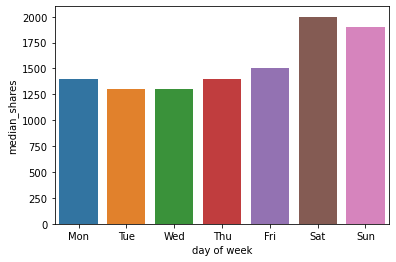

In [3]:

shares = []
for d in [' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday']:
    shares.append(data[data[d]==1][' shares'].median())

    #sns.distplot(data[data[d]==1][' shares'].apply(np.log))
    #plt.show()
ax = sns.barplot(x= ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], y= shares)
ax.set(xlabel='day of week', ylabel='median_shares')
plt.show()

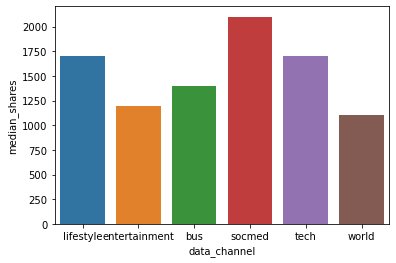

In [4]:

channel = []
for d in [' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world']:
    channel.append(data[data[d]==1][' shares'].median())

    #sns.distplot(data[data[d]==1][' shares'].apply(np.log))
    #plt.show()
ax = sns.barplot(x= ['lifestyle',
       'entertainment', 'bus',
       'socmed', 'tech',
       'world'], y= channel)
ax.set(xlabel='data_channel', ylabel='median_shares')
plt.show()

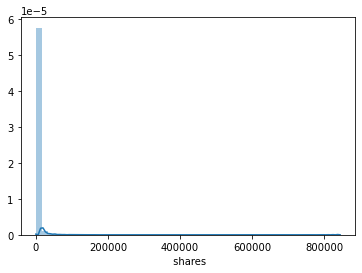

In [5]:
sns.distplot(data[' shares'])
plt.show()

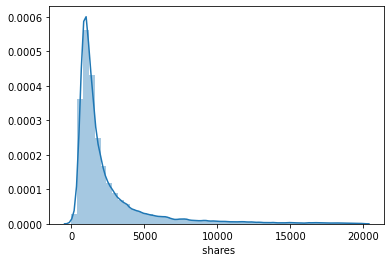

In [6]:
sns.distplot(data[data[' shares']<20000][' shares'])
plt.show()

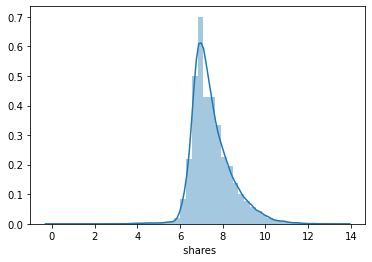

In [7]:
sns.distplot(data[' shares'].apply(np.log))
plt.show()

In [8]:
#custom coding
#applying minmax normalization to the data
#contributed by Vedasri
new_data = deepcopy(data)
del new_data['url']
del new_data[' timedelta']
new_data = new_data.apply(pd.to_numeric, errors='coerce')
columns = set(new_data.columns)
columns.remove(' shares')
for feature_name in list(columns):
    max_value = new_data[feature_name].max()
    min_value = new_data[feature_name].min()
    new_data[feature_name] = (new_data[feature_name] - min_value) / (max_value - min_value)

In [9]:
pca = PCA(n_components = 3)
#ca.fit(new_data)
principalComponents = pca.fit(data[list(columns)])
print(pca.explained_variance_ratio_)  
#print(pca.components_)  
comp = pca.components_
pca_trans = pca.transform(data[list(columns)])
#pd.DataFrame(data = new_data)

[0.7628241  0.16383047 0.03532646]


In [10]:
new_data[' shares'] = new_data[' shares'].apply(np.log)
new_data[' shares'].median()

7.24422751560335

In [11]:

nom_vals = list(np.where(new_data[' shares']<=7, 'r', 'b'))
data3 = np.array(pca_trans)

In [12]:
import matplotlib.cm as cm

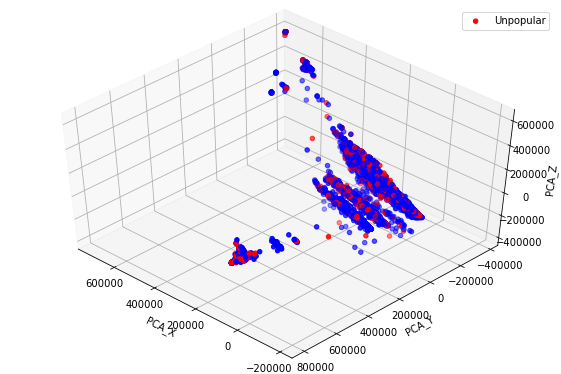

In [13]:
#Custom Coding
#Plotting principal components in 3D.
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(8, 5))

ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

#y = np.choose(new_data, [0,1]).astype(float)
ax.scatter(data3[:, 1], data3[:, 0], data3[:, 2], c=nom_vals, cmap=cm.get_cmap("Spectral"),label=['Unpopular','Popular']
          )
ax.set_xlabel("PCA_X")
ax.set_ylabel("PCA_Y")
ax.set_zlabel("PCA_Z")
ax.legend(['Unpopular','Popular'])
plt.show()

In [14]:
#Custom coding
#finding pairs of attributes that have correlation coefficient between 0.8 and 1.0
c = data[list(columns)].corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort")
so = pd.DataFrame(data=so, columns=['Pearson Coeff'])
so = so[(so['Pearson Coeff'] >= 0.8) & (so['Pearson Coeff'] < 1.0)]
so.iloc[::2]

Pearson Coeff
 kw_max_avg                  kw_avg_avg                      0.811864
 self_reference_avg_sharess  self_reference_min_shares       0.818907
 data_channel_is_world       LDA_02                          0.836618
 self_reference_avg_sharess  self_reference_max_shares       0.853480
 kw_max_max                  kw_min_min                      0.857226
 kw_max_min                  kw_avg_min                      0.940529
 n_non_stop_words            n_non_stop_unique_tokens        0.999532
 n_unique_tokens             n_non_stop_words                0.999572
 n_non_stop_unique_tokens    n_unique_tokens                 0.999852

In [15]:
#custom coding
#feature subset selection
listt = [' weekday_is_saturday',' weekday_is_sunday',' kw_min_min', ' kw_max_min',
       ' kw_min_max', ' kw_max_max', ' kw_min_avg',
       ' kw_max_avg', ' self_reference_min_shares',
       ' self_reference_max_shares',' n_non_stop_words',' min_positive_polarity', ' max_positive_polarity',' min_negative_polarity',
       ' max_negative_polarity']

for i in listt:
    columns.remove(i)

In [16]:
rd = pd.DataFrame(data = listt)
rd

0
0          weekday_is_saturday
1            weekday_is_sunday
2                   kw_min_min
3                   kw_max_min
4                   kw_min_max
5                   kw_max_max
6                   kw_min_avg
7                   kw_max_avg
8    self_reference_min_shares
9    self_reference_max_shares
10            n_non_stop_words
11       min_positive_polarity
12       max_positive_polarity
13       min_negative_polarity
14       max_negative_polarity

In [17]:
columns_all = columns
columns_all.add(' shares')

In [18]:
#Custom coding
#splitting the given data into training and test data.
#Also discretized the shares attribute for classification problems
sel_df = new_data[list(columns_all)]
sel_df['shares_nom'] = np.where(sel_df[' shares']<=7,0,1)
train_df = sel_df.sample(frac=0.75, random_state = 150)
test_df = sel_df.drop(train_df.index)
train_y = train_df[' shares']
train_y_nom = train_df['shares_nom']
del train_df[' shares']
del train_df['shares_nom']
test_y = test_df[' shares']
test_nom_y = test_df['shares_nom']
del test_df[' shares']
del test_df['shares_nom']

C:\Users\C-Jayesh.P\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


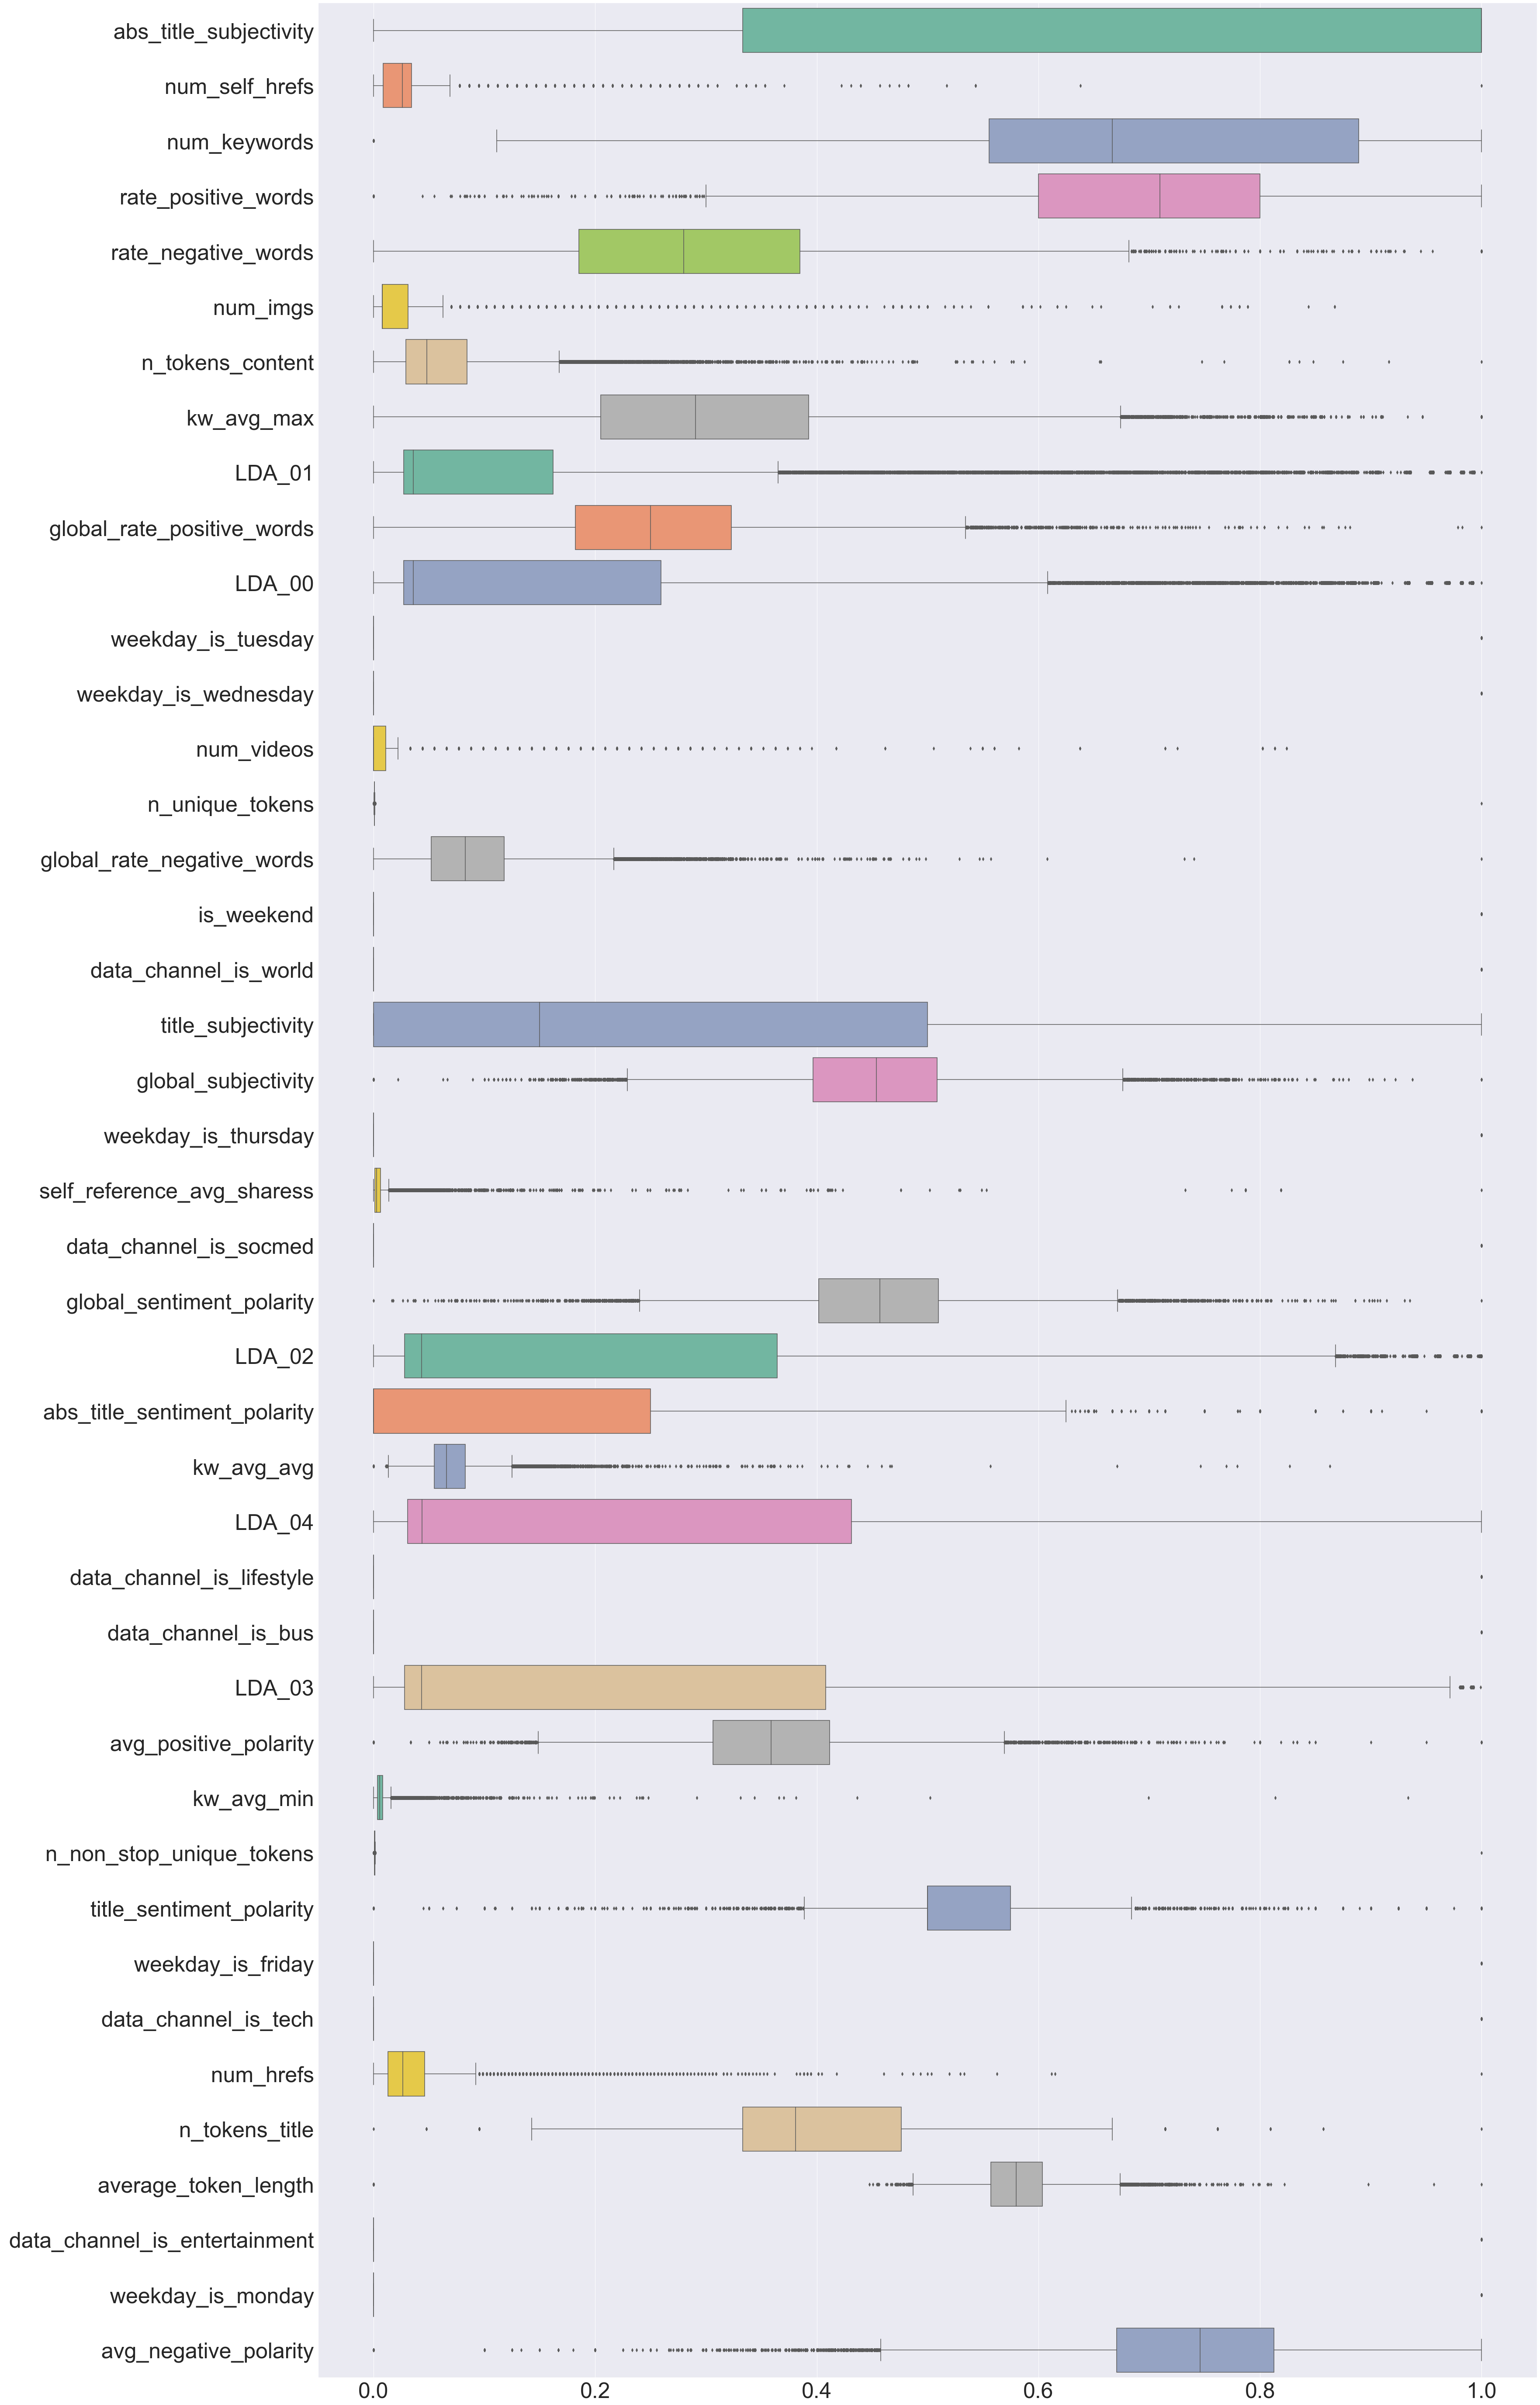

In [19]:
import matplotlib.pyplot as plt
sns.set()
rc={'font.size': 32, 'axes.labelsize': 32, 'legend.fontsize': 32.0, 
    'axes.titlesize': 32, 'xtick.labelsize': 50, 'ytick.labelsize': 50}
plt.rcParams.update(**rc)

fig2, ax2 = plt.subplots(nrows=1, ncols=1,figsize=(50, 100))
b = sns.boxplot(data=train_df, orient="h", palette="Set2", ax = ax2)
plt.show()

In [20]:
X = train_df
y = train_y
clf = linear_model.LinearRegression(normalize=True)
clf.fit(X, y)
print("coeff ",clf.coef_)
print("intercept ",clf.intercept_)
print("score ",clf.score(test_df, test_y))
predictions = clf.predict(test_df)

coeff  [ 7.51113453e-02 -1.03907548e+00  1.06985666e-01  2.31418048e-01
  1.88826949e-02  3.64857127e-01  2.81464643e-01 -2.93078190e-01
 -3.89182762e+01 -1.25865847e-01 -3.86610476e+01  3.18460945e+11
  3.18460945e+11  1.87618233e-01  6.44729197e+01  2.67702929e-01
  3.18460945e+11 -1.49119734e-01  3.91313267e-02  4.71609915e-01
  3.18460945e+11  1.49306404e+00  1.28815856e-01 -1.96330795e-01
 -3.88240082e+01  3.08893193e-02  5.96547315e+00 -3.88908210e+01
 -1.34352983e-01 -2.32306856e-01 -3.88779269e+01 -9.83211908e-02
 -3.82867957e+00 -1.04675651e+02  2.08086080e-01  3.18460945e+11
  3.29834669e-02  1.60500083e+00  1.53850628e-01 -7.80424639e-01
 -3.02295839e-01  3.18460945e+11 -1.29063656e-01]
intercept  -318460945050.72394
score  0.10699811777302226


In [21]:
#lasso
from sklearn import linear_model
print(len(train_df.columns))
X = train_df
y = np.exp(train_y)
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X, y)
print("coefficient\n",clf.coef_)
print(len(clf.coef_))
print("iterations\n",clf.n_iter_)
print("intercept\n",clf.intercept_)
print("train data score\n",clf.score(train_df, y))
print("test data score\n",clf.score(test_df, np.exp(test_y)))
predictions = clf.predict(test_df)

43
coefficient
 [ 3.91756778e+02 -6.97004208e+03  5.43580606e+02  1.02757152e+03
 -0.00000000e+00  1.00188332e+03  9.94190600e+02 -8.81298708e+02
 -7.34486668e+02 -1.52676859e+03  1.56381262e+02 -2.14561067e+02
  5.75355119e-02  5.31760711e+01  2.57934348e+03  1.36489276e+03
  1.92142132e+02 -1.13787107e+03 -2.59434934e+02  2.95237144e+03
 -2.48456238e+02  1.83302645e+04 -1.00390252e+03 -0.00000000e+00
 -1.40546251e+03  9.60168927e+02  2.83395960e+04 -6.74252592e+02
 -1.38532668e+03 -1.43266346e+03  1.45003782e+02 -2.00786267e+03
  4.03915108e+02  0.00000000e+00  4.34241787e+02 -1.29616190e+02
 -9.76494017e+02  1.20660514e+04  2.29934716e+03 -4.07206905e+03
 -1.88798350e+03  4.10682045e+02 -2.04354731e+03]
43
iterations
 1000
intercept
 3789.6026675299436
train data score
 0.02102045884630377
test data score
 0.012826457241083666


C:\Users\C-Jayesh.P\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 642168556.4619141, tolerance: 471028616.59580433
  positive)


In [22]:
X = train_df
y = train_y_nom
clf = linear_model.LogisticRegression()
clf.fit(X, y)
print(clf.coef_)
print(clf.intercept_)
print(clf.score(test_df, test_nom_y))
predictions = clf.predict(test_df)

[[ 0.14747159 -1.60953751  0.14292506 -0.20842292 -0.50841601  0.71587347
   1.4620297  -0.35560196 -0.22860563 -0.14526295  0.48444388 -0.26519296
  -0.29872812  0.18183648  0.24335699  0.43562076  0.98065408 -0.20300404
   0.02866482  0.92176294 -0.24130548  3.7655975   1.17233847  0.05627804
  -0.54034383  0.08707539  8.64122951  0.19412214  0.0315581  -0.26447217
  -0.10087145 -0.35270146 -0.58348211  0.23560797  0.35511119  0.05230924
   0.37939679  2.7814605  -0.01739539 -0.7433927  -0.55128297 -0.13339606
  -0.13147056]]
[0.39597909]
0.7026536171930179


C:\Users\C-Jayesh.P\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
>>> from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [25]:
rf = RandomForestClassifier(n_estimators = 100, max_depth = 20, bootstrap = True)   

X = train_df
y = train_y_nom

rf.fit(X,y) 
y_pred = rf.predict(test_df)
probs = rf.predict_proba(test_df)
#print("Confusion matrix:\n%s" % cm)
print("Accuracy is %s" % accuracy_score(test_nom_y, y_pred))

print(classification_report(test_nom_y, y_pred))

Accuracy is 0.713954192311573
              precision    recall  f1-score   support

           0       0.58      0.29      0.38      3084
           1       0.74      0.91      0.81      6827

    accuracy                           0.71      9911
   macro avg       0.66      0.60      0.60      9911
weighted avg       0.69      0.71      0.68      9911



In [26]:
df_confusion = pd.crosstab(test_nom_y, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(df_confusion)

Predicted     0     1   All
Actual                     
0           885  2199  3084
1           636  6191  6827
All        1521  8390  9911


In [27]:
columns.remove(' shares')

                         attribute  importance
26                      kw_avg_avg    0.063723
21      self_reference_avg_sharess    0.045181
24                          LDA_02    0.042054
32                      kw_avg_min    0.040000
7                       kw_avg_max    0.039556
8                           LDA_01    0.037073
27                          LDA_04    0.036003
10                          LDA_00    0.034896
33        n_non_stop_unique_tokens    0.034631
39            average_token_length    0.034392
19             global_subjectivity    0.033735
14                 n_unique_tokens    0.033522
6                 n_tokens_content    0.033400
30                          LDA_03    0.033359
31           avg_positive_polarity    0.033179
9       global_rate_positive_words    0.032981
23       global_sentiment_polarity    0.032455
42           avg_negative_polarity    0.030252
15      global_rate_negative_words    0.029673
3              rate_positive_words    0.026237
4            

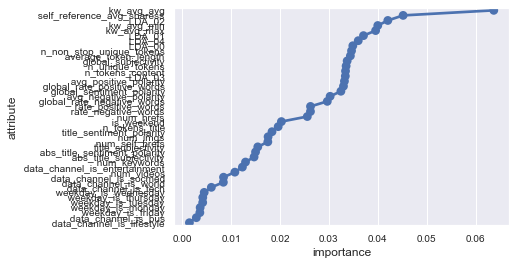

In [28]:
#Custom coding
#Retrieving feature importances from the Random Forest model
rf_feature = pd.DataFrame(data = list(columns),columns = ['attribute'])
rf_feature['importance'] = rf.feature_importances_

rf_feature = rf_feature.sort_values(by='importance', ascending = False)
print(rf_feature)
rf_sel = list(rf_feature[rf_feature['importance']>0.01]['attribute'])
rf_sel

rc={'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 12.0, 
    'axes.titlesize': 12, 'xtick.labelsize': 10, 'ytick.labelsize': 10}
plt.rcParams.update(**rc)
sns.pointplot(x='importance', y='attribute', data=rf_feature)
plt.show()

2   0.6888305922712138
Accuracy is 0.6888305922712138
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3084
           1       0.69      1.00      0.82      6827

    accuracy                           0.69      9911
   macro avg       0.34      0.50      0.41      9911
weighted avg       0.47      0.69      0.56      9911



C:\Users\C-Jayesh.P\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6   0.7017455352638482
Accuracy is 0.7017455352638482
              precision    recall  f1-score   support

           0       0.63      0.10      0.18      3084
           1       0.71      0.97      0.82      6827

    accuracy                           0.70      9911
   macro avg       0.67      0.54      0.50      9911
weighted avg       0.68      0.70      0.62      9911

10   0.7111290485319343
Accuracy is 0.7111290485319343
              precision    recall  f1-score   support

           0       0.60      0.21      0.31      3084
           1       0.72      0.94      0.82      6827

    accuracy                           0.71      9911
   macro avg       0.66      0.57      0.56      9911
weighted avg       0.69      0.71      0.66      9911

14   0.7166784380990818
Accuracy is 0.7166784380990818
              precision    recall  f1-score   support

           0       0.60      0.27      0.37      3084
           1       0.74      0.92      0.82      6827

    accuracy      

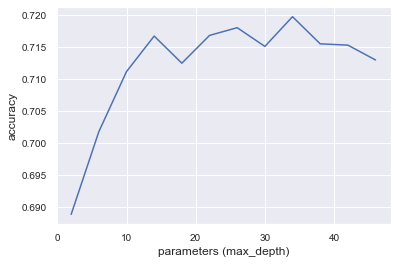

In [29]:
#Custom coding to see how the performace is changing by varying parameter max_depth in random forest.
a = []
b = []
for j in range(2,50,4):
    rf = RandomForestClassifier(n_estimators = 100, max_depth = j, bootstrap = True)   

    X = train_df
    y = train_y_nom

    rf.fit(X,y) 
    y_pred = rf.predict(test_df)
    probs = rf.predict_proba(test_df)
        #print("Confusion matrix:\n%s" % cm)
    acc = accuracy_score(test_nom_y, y_pred)
    a.append(j)
    b.append(acc)
    print(j," ",acc)
    print("Accuracy is %s" % acc)
    print(classification_report(test_nom_y, y_pred))
        
plt.plot(a,b)
plt.xlabel('parameters (max_depth)')
plt.ylabel('accuracy')
plt.show()

10   0.6763192412470992
Accuracy is 0.6763192412470992
              precision    recall  f1-score   support

           0       0.47      0.38      0.42      3084
           1       0.74      0.81      0.78      6827

    accuracy                           0.68      9911
   macro avg       0.61      0.59      0.60      9911
weighted avg       0.66      0.68      0.66      9911

30   0.7141559882958329
Accuracy is 0.7141559882958329
              precision    recall  f1-score   support

           0       0.57      0.33      0.42      3084
           1       0.75      0.89      0.81      6827

    accuracy                           0.71      9911
   macro avg       0.66      0.61      0.61      9911
weighted avg       0.69      0.71      0.69      9911

50   0.7137523963273131
Accuracy is 0.7137523963273131
              precision    recall  f1-score   support

           0       0.57      0.31      0.40      3084
           1       0.74      0.89      0.81      6827

    accuracy     

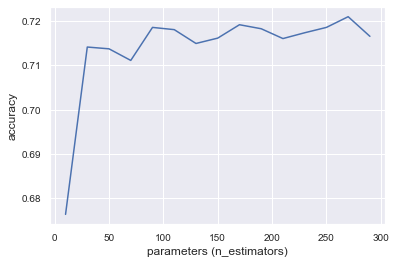

In [30]:
#Custom coding to see how the performace is changing by varying parameter n_estimators in random forest.
a = []
b = []
for j in range(10,300,20):
    rf = RandomForestClassifier(n_estimators = j, max_depth = 24, bootstrap = True)   

    X = train_df
    y = train_y_nom

    rf.fit(X,y) 
    y_pred = rf.predict(test_df)
    probs = rf.predict_proba(test_df)
        #print("Confusion matrix:\n%s" % cm)
    acc = accuracy_score(test_nom_y, y_pred)
    a.append(j)
    b.append(acc)
    print(j," ",acc)
    print("Accuracy is %s" % acc)
    print(classification_report(test_nom_y, y_pred))
        
plt.plot(a,b)
plt.xlabel('parameters (n_estimators)')
plt.ylabel('accuracy')
plt.show()

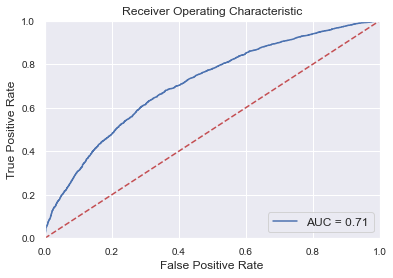

In [31]:
#Custom coding by choosing optimal value for the parameters and plotting the ROC Curve
rf = RandomForestClassifier(n_estimators = 50, max_depth = 22, bootstrap = True)   

X = train_df
y = train_y_nom

rf.fit(X,y) 
probs = rf.predict_proba(test_df)

fpr, tpr, thresholds = metrics.roc_curve(test_nom_y, probs[:, 1])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [32]:
#custom coding
#detecting outliers in data using 1.5IQR rule
#contributed by Pavani
out_data = deepcopy(sel_df)
for i, var_name in enumerate(out_data.columns):
        q75, q25 = np.percentile(out_data[var_name], [75 ,25])
        iqr = q75 - q25
        
        min = q25 - (iqr*1.5)
        max = q75 + (iqr*1.5)
        out_data = out_data.drop(out_data.loc[out_data[var_name] < min].index)
        out_data = out_data.drop(out_data.loc[out_data[var_name] > max].index)
len(out_data)

3927

In [33]:
len(data)

39644

Accuracy is 0.42891736454444557
              precision    recall  f1-score   support

           0       0.34      0.92      0.50      3084
           1       0.85      0.21      0.33      6827

    accuracy                           0.43      9911
   macro avg       0.60      0.56      0.42      9911
weighted avg       0.69      0.43      0.39      9911



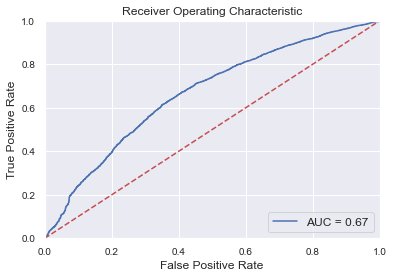

In [34]:
from sklearn.naive_bayes import GaussianNB
>>> gnb = GaussianNB()
X = train_df
y = train_y_nom

gnb.fit(X,y) 
y_pred = gnb.predict(test_df)
probs = gnb.predict_proba(test_df)
#print("Confusion matrix:\n%s" % cm)
print("Accuracy is %s" % accuracy_score(test_nom_y, y_pred))

print(classification_report(test_nom_y, y_pred))
fpr, tpr, thresholds = metrics.roc_curve(test_nom_y, probs[:, 1])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Accuracy is 0.7125416204217536
                         attribute  importance
26                      kw_avg_avg    0.214210
22          data_channel_is_socmed    0.103481
16                      is_weekend    0.087013
21      self_reference_avg_sharess    0.074367
10                          LDA_00    0.061707
7                       kw_avg_max    0.055847
1                   num_self_hrefs    0.049197
40   data_channel_is_entertainment    0.045667
2                     num_keywords    0.039216
14                 n_unique_tokens    0.036964
17           data_channel_is_world    0.033938
36            data_channel_is_tech    0.026098
5                         num_imgs    0.019239
33        n_non_stop_unique_tokens    0.017853
8                           LDA_01    0.014813
35               weekday_is_friday    0.014562
34        title_sentiment_polarity    0.013431
32                      kw_avg_min    0.013117
37                       num_hrefs    0.011826
13                      num_v

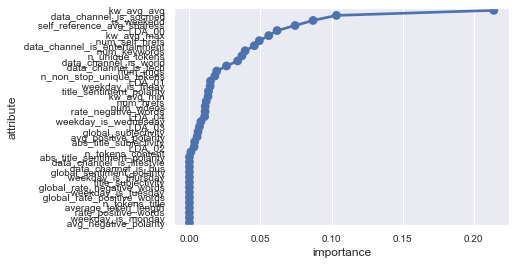

10   0.699929371405509
              precision    recall  f1-score   support

           0       0.57      0.15      0.23      3084
           1       0.71      0.95      0.81      6827

    accuracy                           0.70      9911
   macro avg       0.64      0.55      0.52      9911
weighted avg       0.67      0.70      0.63      9911

30   0.7073958228231259
              precision    recall  f1-score   support

           0       0.56      0.30      0.39      3084
           1       0.74      0.89      0.81      6827

    accuracy                           0.71      9911
   macro avg       0.65      0.60      0.60      9911
weighted avg       0.68      0.71      0.68      9911

50   0.7106245585712845
              precision    recall  f1-score   support

           0       0.56      0.31      0.40      3084
           1       0.74      0.89      0.81      6827

    accuracy                           0.71      9911
   macro avg       0.65      0.60      0.60      9911
wei

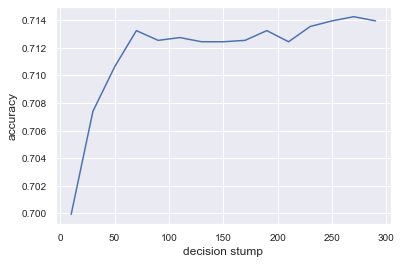

In [35]:
#Custom coding for Adaboost to get feature importances and to see how model is varying by changing the parameters.
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles


X = train_df  # we only take the first two features.
Y = train_y_nom

# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)

bdt.fit(X, Y)
Z = bdt.predict(test_df)
print("Accuracy is %s" % accuracy_score(test_nom_y, Z))

abc_feature = pd.DataFrame(data = list(columns),columns = ['attribute'])
abc_feature['importance'] = bdt.feature_importances_

abc_feature = abc_feature.sort_values(by='importance', ascending = False)
print(abc_feature)
abc_sel = list(abc_feature[abc_feature['importance']>0]['attribute'])
abc_sel
sns.pointplot(x='importance', y='attribute', data=abc_feature)
plt.show()


X = train_df[abc_sel]  # we only take the first two features.
Y = train_y_nom

a = []
b = []
for i in range(10,300,20):
    bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=i)

    bdt.fit(X, Y)

    Z = bdt.predict(test_df[abc_sel])
    acc = accuracy_score(test_nom_y, Z)
    a.append(i)
    b.append(acc)
    print(i," ",acc)
    print(classification_report(test_nom_y, Z))
plt.plot(a,b)
plt.xlabel('decision stump')
plt.ylabel('accuracy')
plt.show()

#bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=250)

#bdt.fit(X, Y)
probs = bdt.predict_proba(test_df)

fpr, tpr, thresholds = metrics.roc_curve(test_nom_y, probs[:, 1])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [36]:
from sklearn.cluster import KMeans
X = sel_df[list(columns)]
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
sel_df['kmeans'] = kmeans.predict(X)
centers = kmeans.cluster_centers_
kmeans.inertia_

C:\Users\C-Jayesh.P\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


88330.2566002515

In [37]:
print(pd.crosstab(sel_df['shares_nom'],sel_df['kmeans']))

kmeans         0      1
shares_nom             
0           3722   8702
1           4709  22511


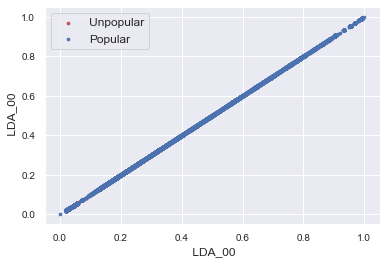

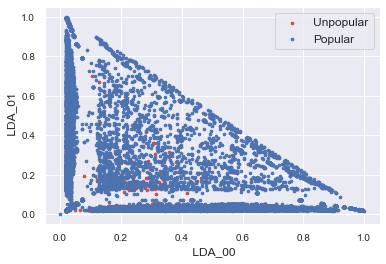

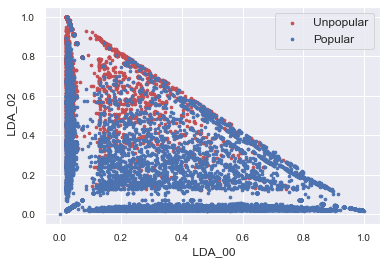

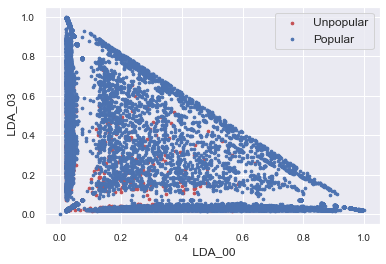

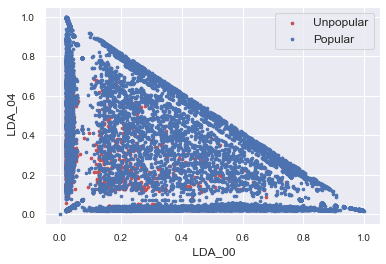

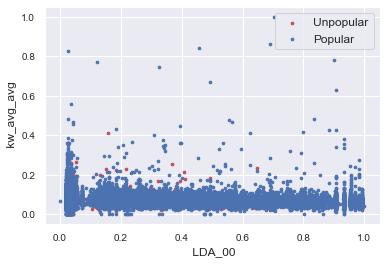

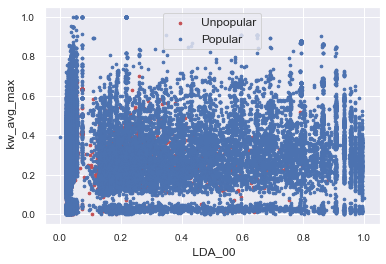

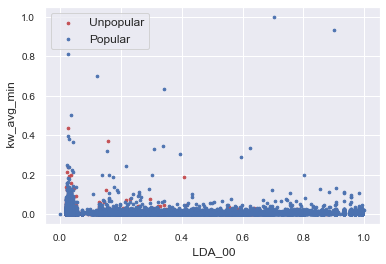

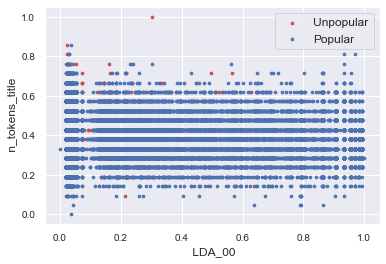

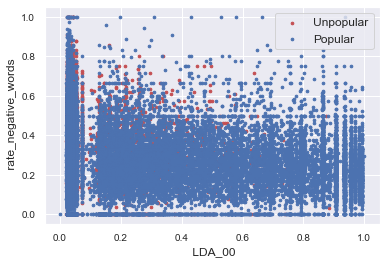

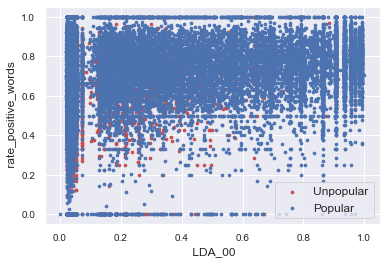

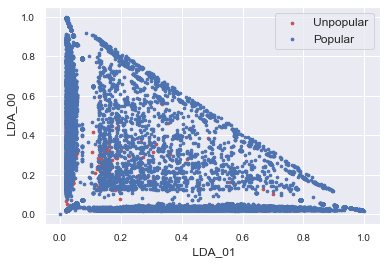

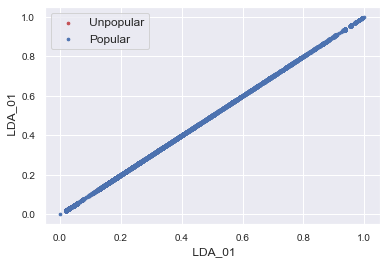

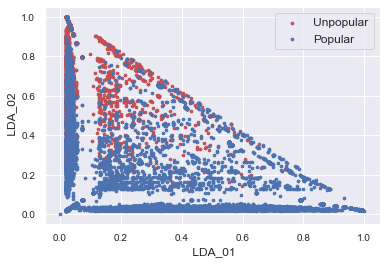

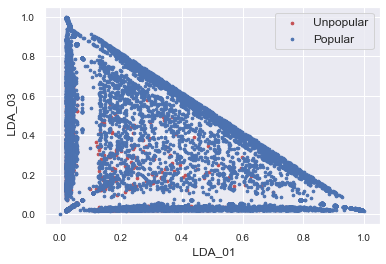

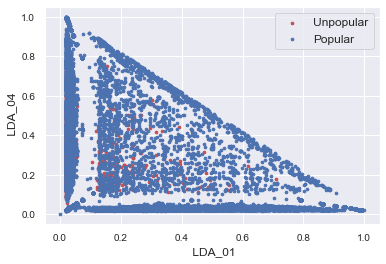

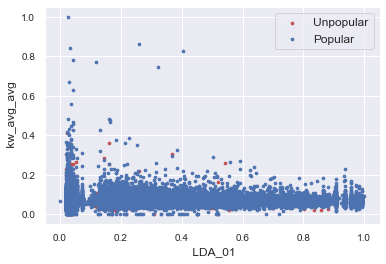

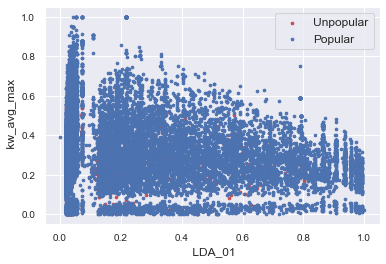

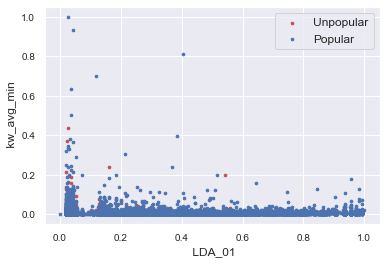

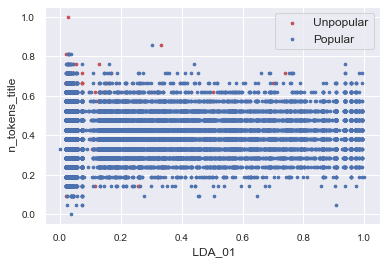

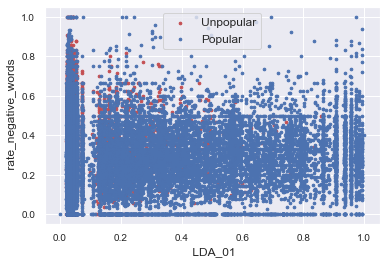

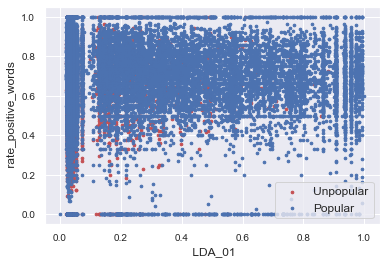

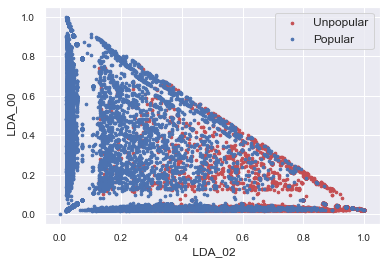

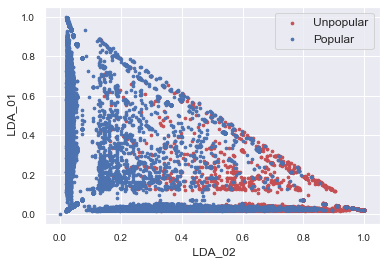

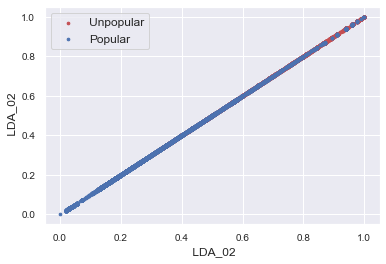

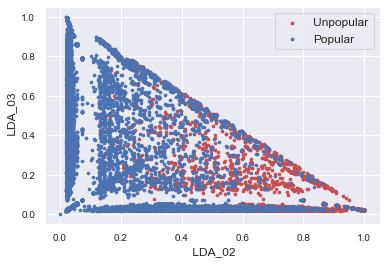

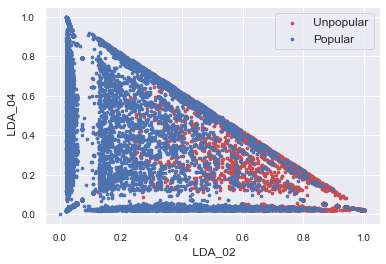

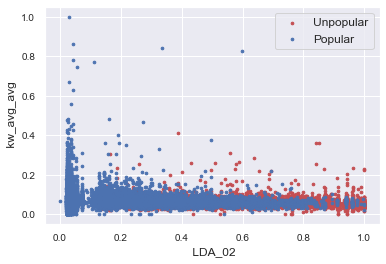

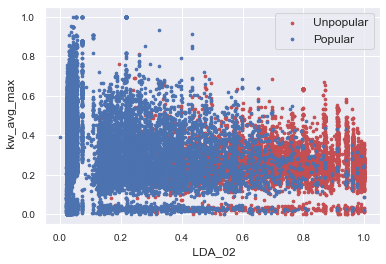

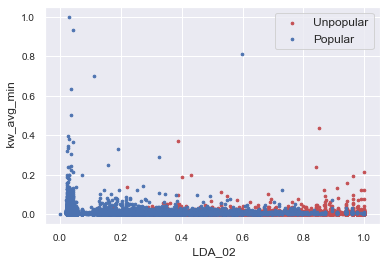

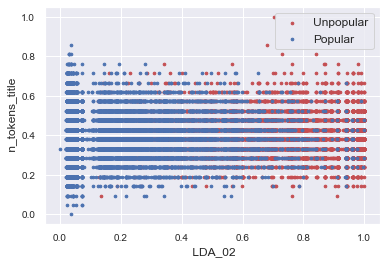

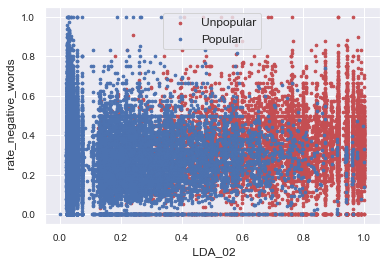

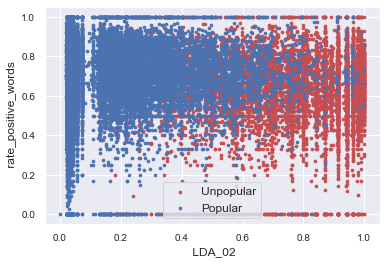

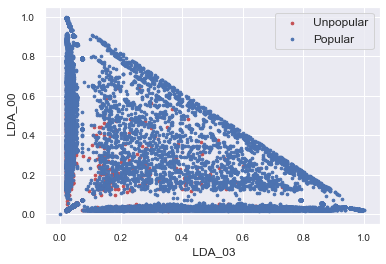

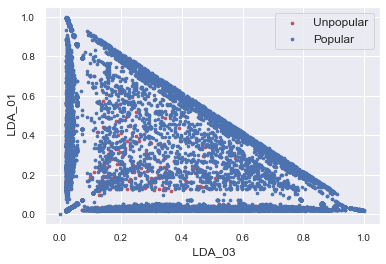

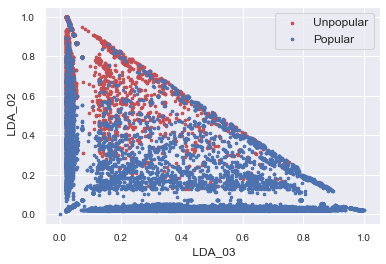

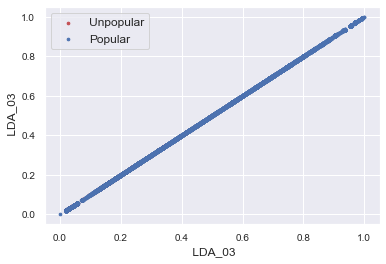

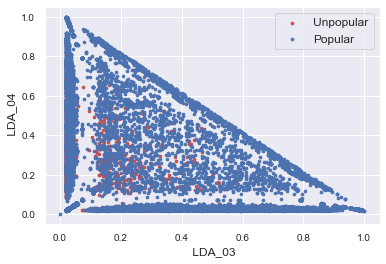

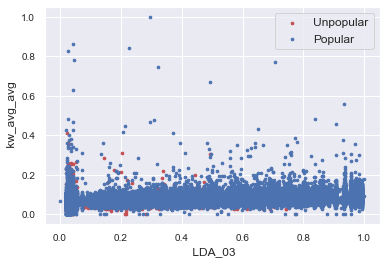

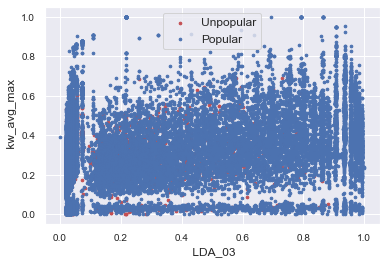

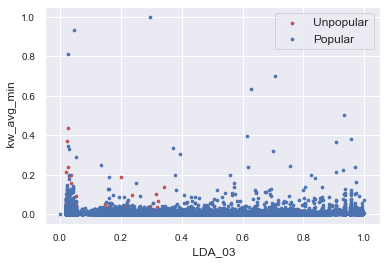

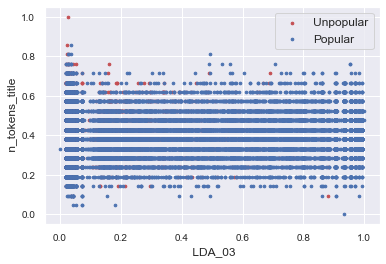

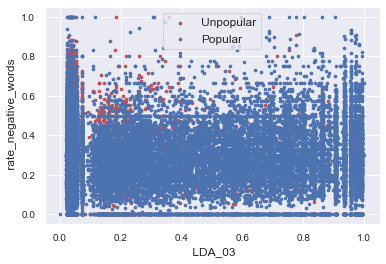

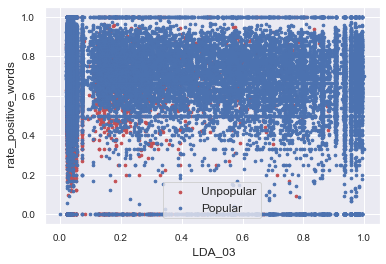

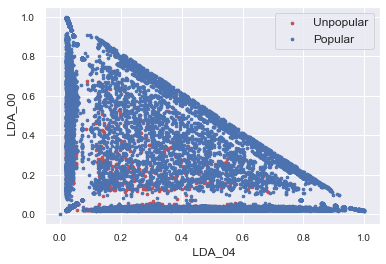

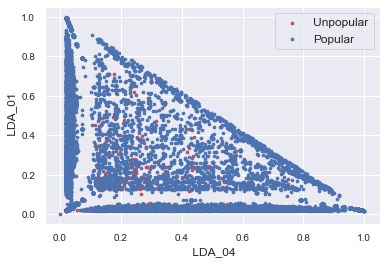

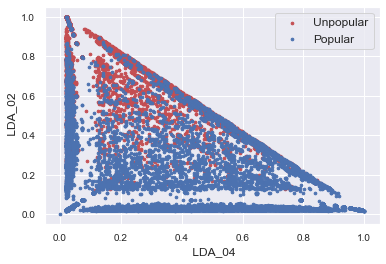

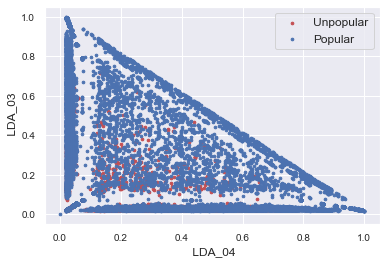

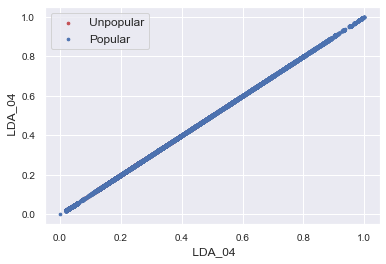

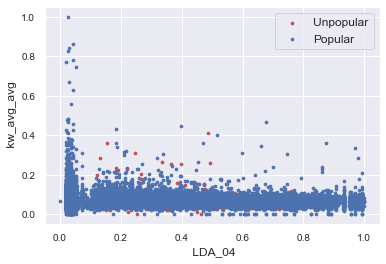

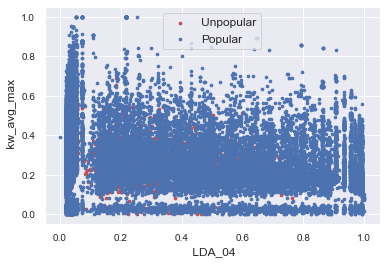

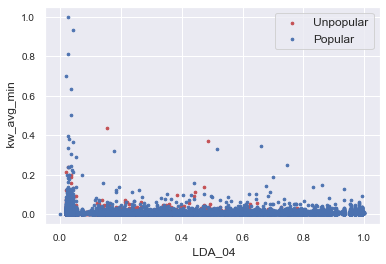

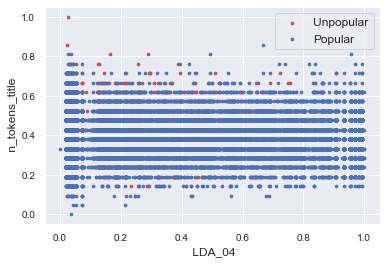

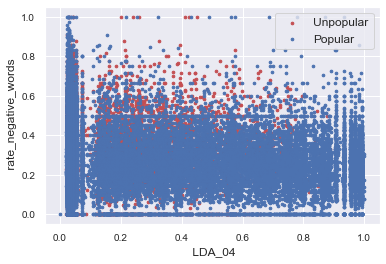

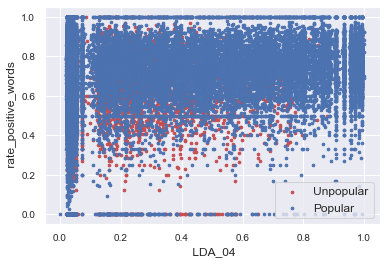

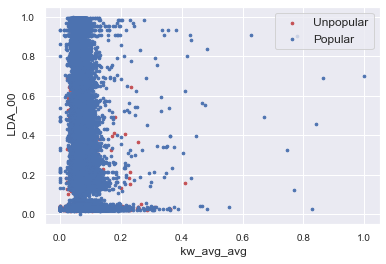

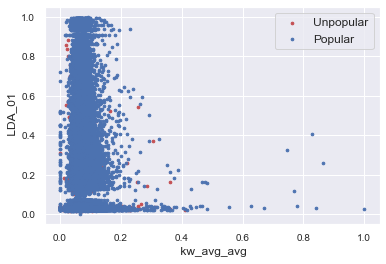

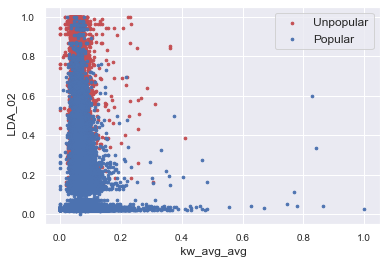

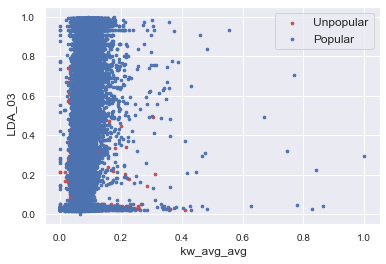

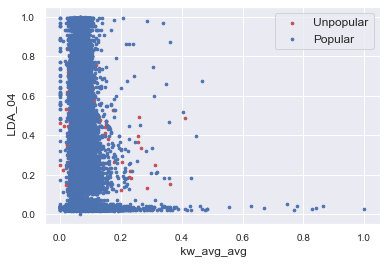

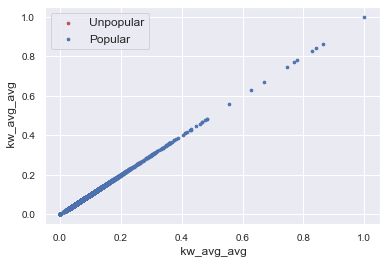

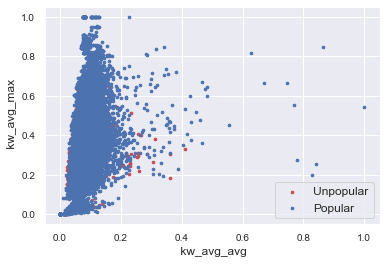

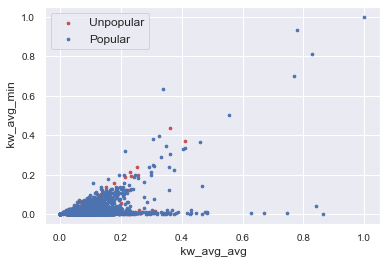

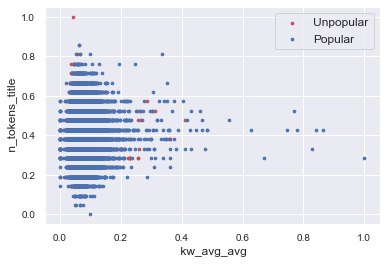

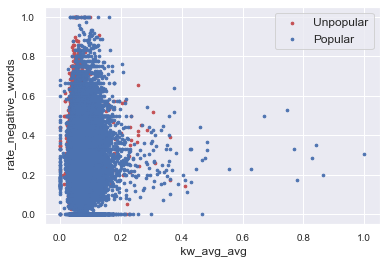

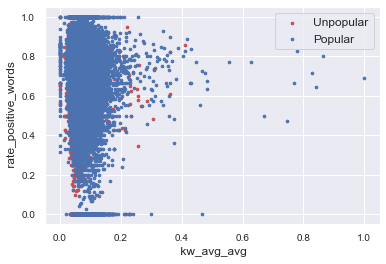

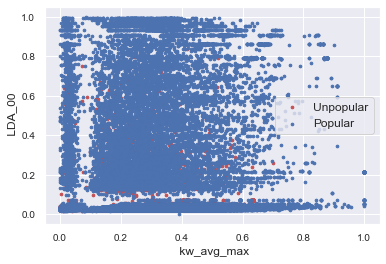

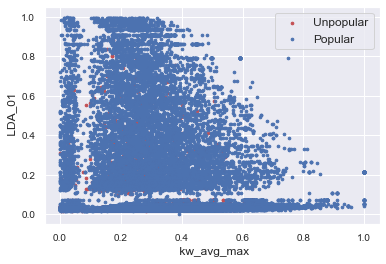

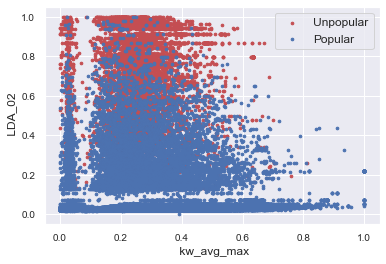

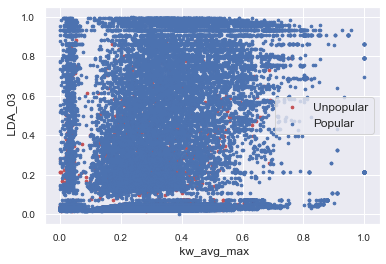

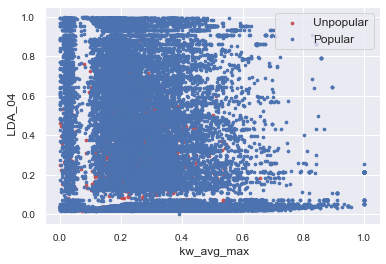

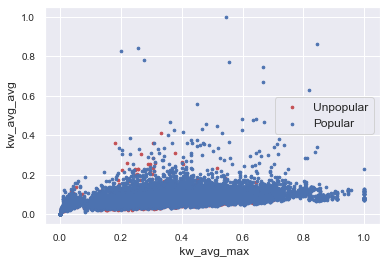

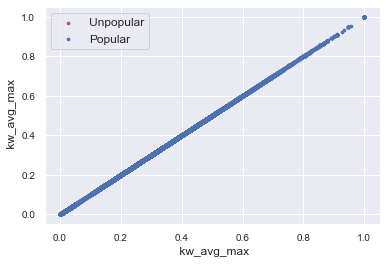

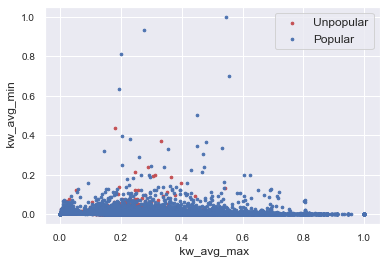

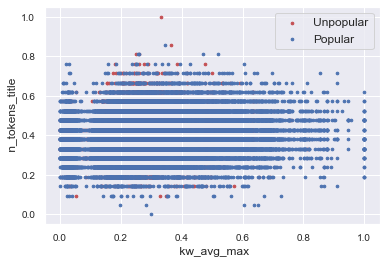

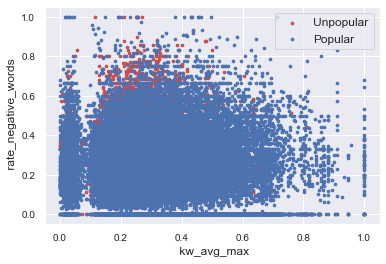

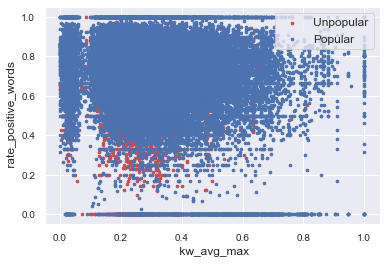

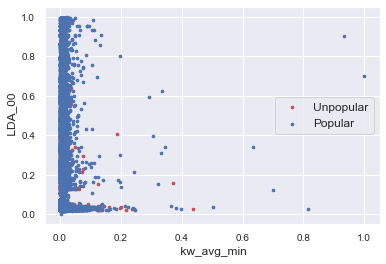

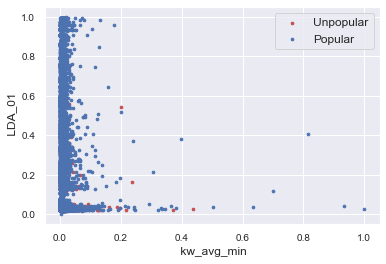

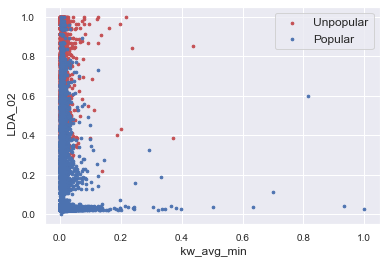

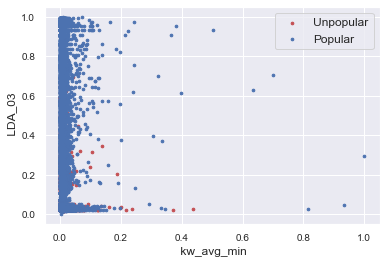

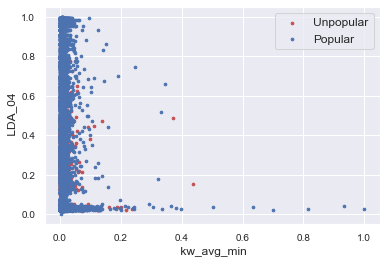

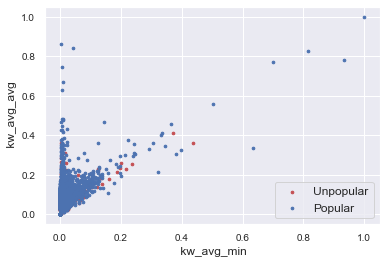

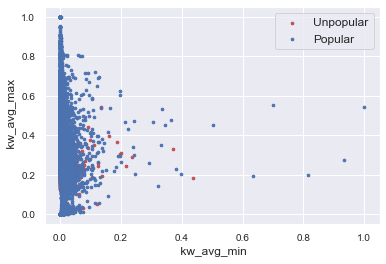

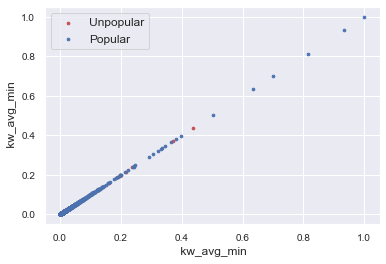

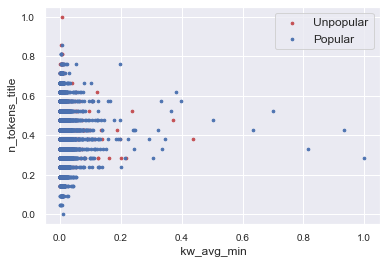

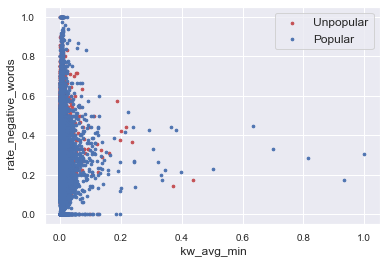

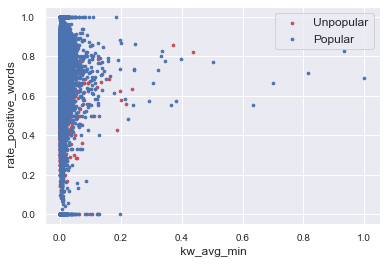

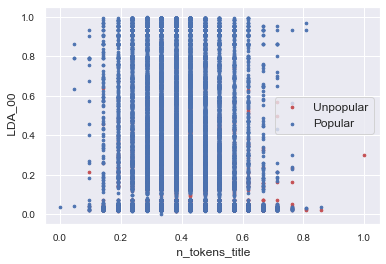

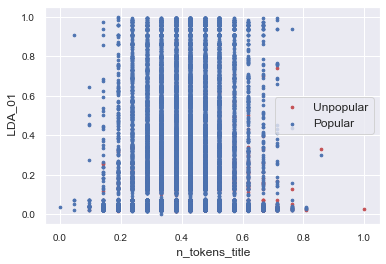

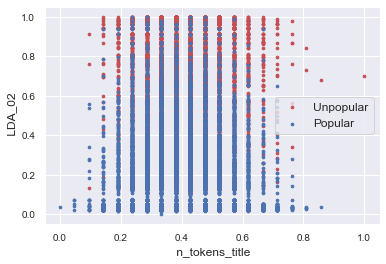

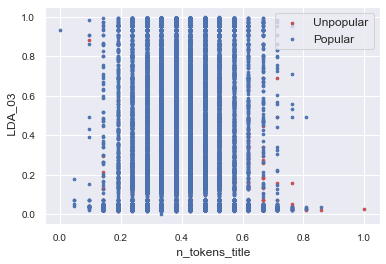

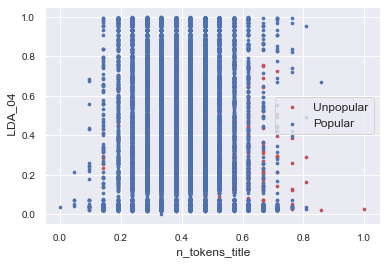

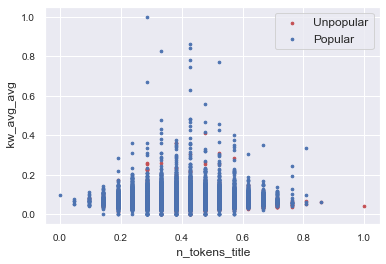

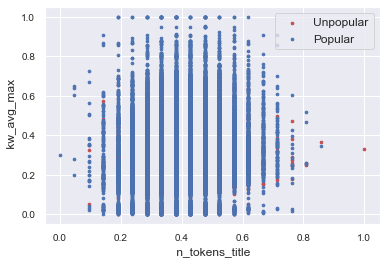

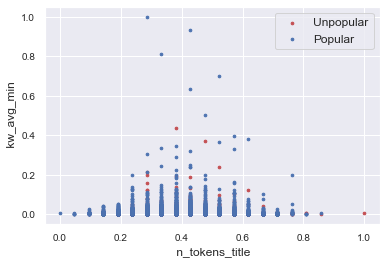

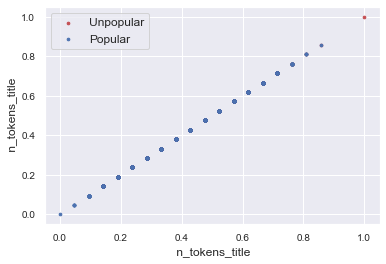

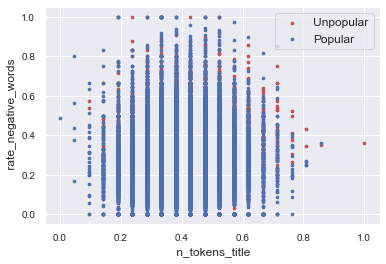

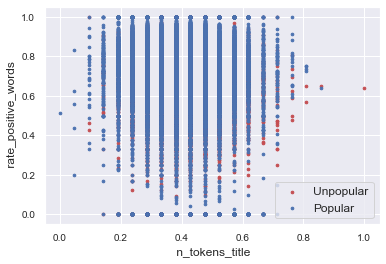

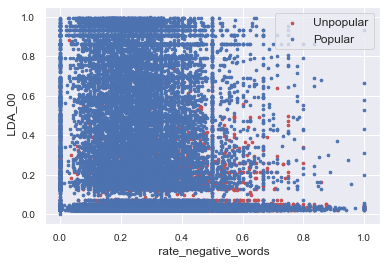

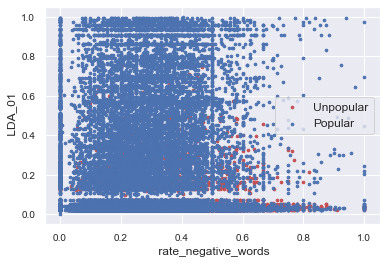

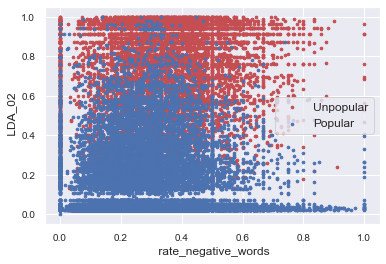

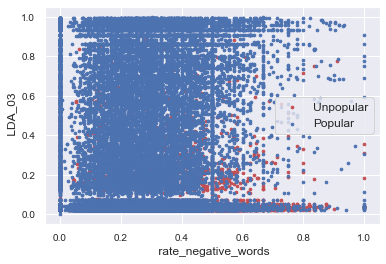

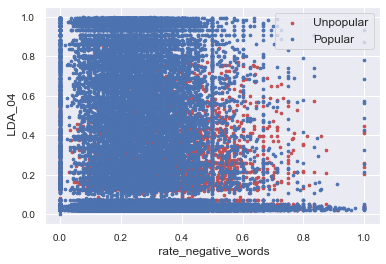

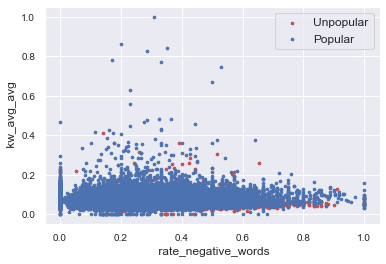

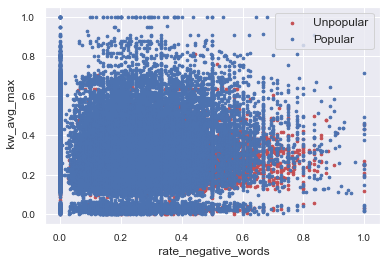

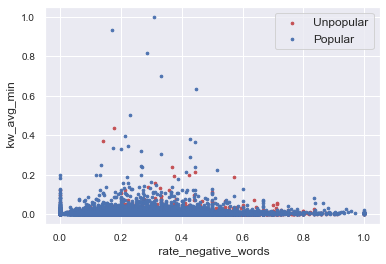

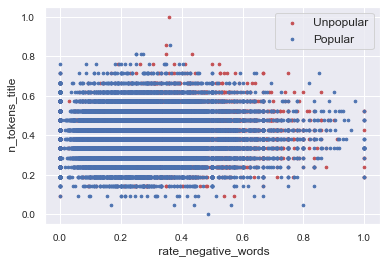

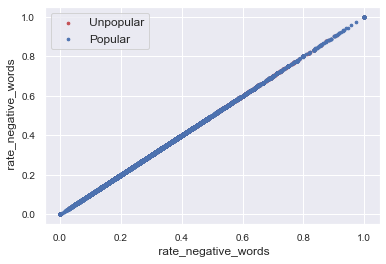

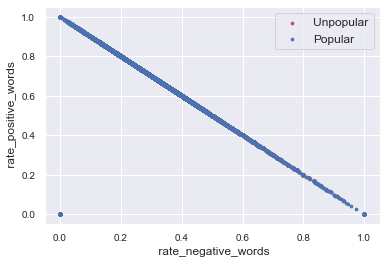

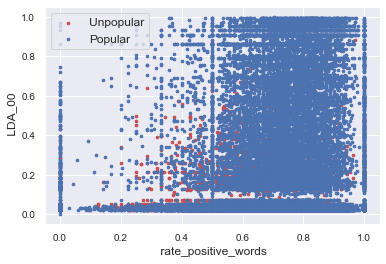

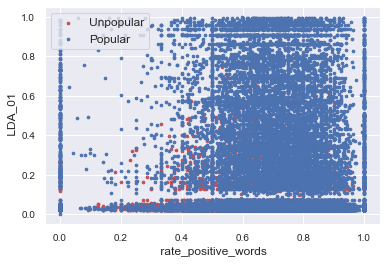

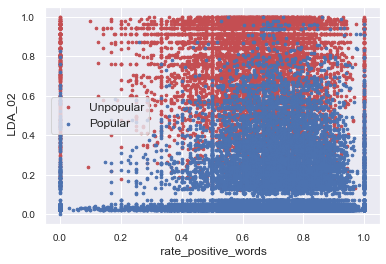

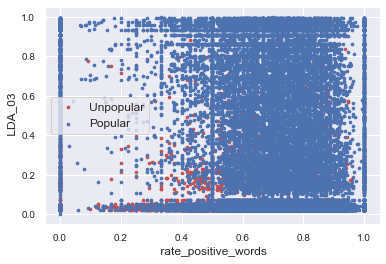

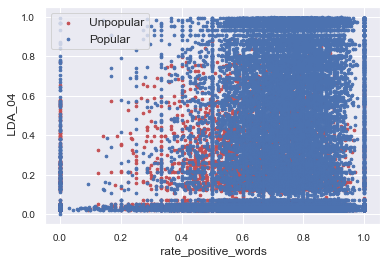

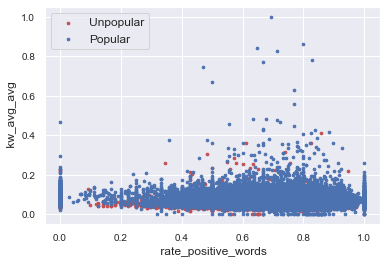

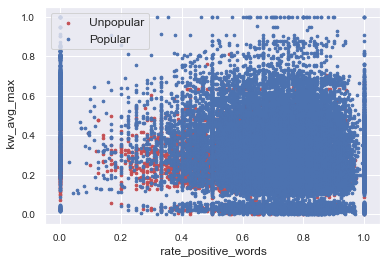

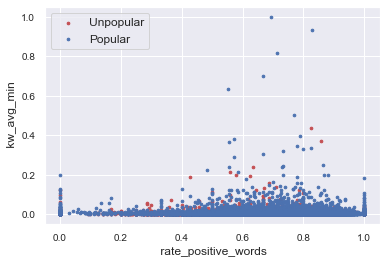

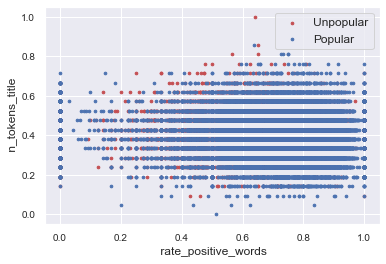

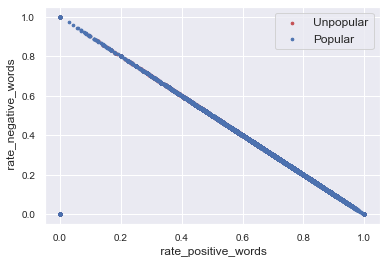

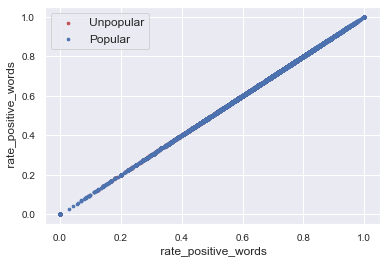

In [38]:
#custom coding to visualize cluster assignments of KMeans Model by plotting certain pairs of attributes
import itertools
list1= [' LDA_00', ' LDA_01', ' LDA_02', ' LDA_03', ' LDA_04',
 ' kw_avg_avg',
 ' kw_avg_max',
 ' kw_avg_min',
 ' n_tokens_title',
 ' rate_negative_words',
 ' rate_positive_words',
 ]
list2= list1
points1 = sel_df.loc[sel_df['kmeans'] == 0]
points2 = sel_df.loc[sel_df['kmeans'] == 1]

for a,b in itertools.product(list1,list2):
    fig, ax = plt.subplots()
    ax.scatter(points1[a], points1[b], s=7, c='r', label = 'Unpopular')
    ax.scatter(points2[a], points2[b], s=7, c='b', label = 'Popular')
    ax.legend()
    plt.xlabel(a)
    plt.ylabel(b)
    plt.show()


import time as time
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets.samples_generator import make_swiss_roll

# Compute clustering
print("Compute unstructured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=2, linkage='ward').fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

ward

sel_df['hierarchical']= ward.labels_


#custom coding to visualize cluster assignments of Agglomerative CLustering Model by plotting certain pairs of attributes

points1 = sel_df.loc[sel_df['ac'] == 0]
points2 = sel_df.loc[sel_df['ac'] == 1]

for a,b in itertools.product(list1,list2):
    fig, ax = plt.subplots()
    ax.scatter(points1[a], points1[b], s=7, c='r', label = 'Unpopular')
    ax.scatter(points2[a], points2[b], s=7, c='b', label = 'Popular')
    ax.legend()
    plt.xlabel(a)
    plt.ylabel(b)
    plt.show()

print(pd.crosstab(sel_df['shares_nom'],sel_df['hierarchical']))